In [ ]:
# default_exp tbptt
# default_cls_lvl 3

In [ ]:
#hide
%matplotlib notebook
from fastai2.callback.progress import *
from fastai2.callback.tracker import *
from fastai2.callback.schedule import *

In [ ]:
#export
from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *

import math

## TBPTT Dataloader
> Pytorch Modules for Training Models for sequential data

The tbptt dataloader needs to split the minibatches that are created in several smaller minibatches that will be returned sequentially before the next minibatch may be created.

In [ ]:
@delegates()
class TbpttDl(TfmdDL):
    def __init__(self, dataset, sub_seq_len=None, seq_len = None ,shuffle=True,num_workers=0, **kwargs):
        self.n_sub_seq = None
        super().__init__(dataset=dataset, shuffle=shuffle, num_workers=num_workers, **kwargs)
        if seq_len is None: seq_len = self.do_item(0)[0].shape[0]
        store_attr(self,'sub_seq_len,seq_len')
        
        if sub_seq_len is not None: self.n_sub_seq = math.ceil(seq_len / sub_seq_len)
        self.rnn_reset = self.n_sub_seq is None #always reset stateful rnns if there are no subsequences
        
    def __len__(self):
#         import pdb; pdb.set_trace()
        if self.n_sub_seq is None:
            return super().__len__()
        else:
            return super().__len__()*self.n_sub_seq
    
    def create_batches(self, samps):
        batch_iter = super().create_batches(samps)
        if self.n_sub_seq is None:
            return batch_iter
        else:
            return self._tbptt_generator(batch_iter)
        
    def _tbptt_generator(self,batch_iter):
        for b in batch_iter:
            for i in range(self.n_sub_seq):
                self.rnn_reset = i == 0
#                 import pdb; pdb.set_trace()
                trunc_b = tuple([x[:,i*self.sub_seq_len:(i+1)*self.sub_seq_len] for x in b])
                yield trunc_b

In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,clm_shift=[-1,-1]),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,clm_shift=[1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=1000+1,stp_sz=100,clm='current')]),
                 splitter=ApplyToDict(ParentSplitter()))
# seq.dl_type=TbpttDl
db = seq.dataloaders(get_hdf_files('test_data/'),dl_type=TbpttDl,sub_seq_len=200)

In [ ]:
db.valid.one_batch()[0].shape

torch.Size([64, 1000, 2])

num_workers has to be 0. If there are parallel workers, the order of minibatches will be corrupted

## TBPTT_Reset_Callback
The stateful model needs to reset its hidden state, when a new sequence begins. The callback reads the reset flag and acts accordingly.

In [ ]:
class TbpttResetCB(Callback):
    "`Callback` resets the rnn model with every new sequence for tbptt"
        
    def begin_batch(self):
        dl = self.learn.dls.train if self.training else self.learn.dls.valid
        if not self.training: import pdb; pdb.set_trace()
        if hasattr(dl,'rnn_reset')and dl.rnn_reset: self.model.reset()

## Example

In [ ]:
lrn = RNNLearner(db,num_layers=1,rnn_type='gru',stateful=False,metrics=[SkipNLoss(fun_rmse,100)])
lrn.add_cb(TbpttResetCB())

<IPython.core.display.Javascript object>


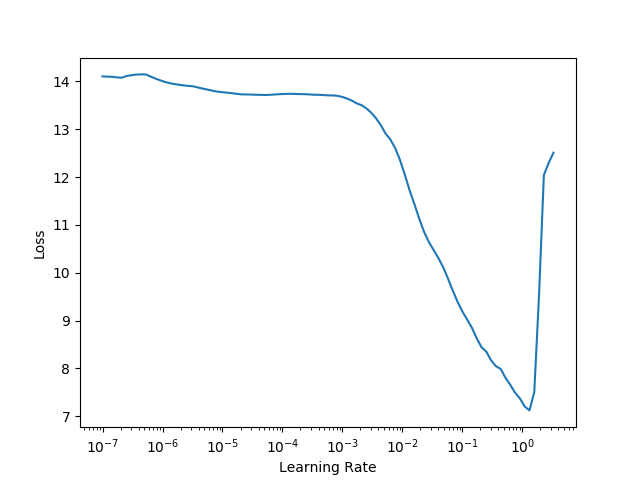

(0.13182567358016967, 0.010964781977236271)

In [ ]:
lrn.lr_find()

In [ ]:
lrn.fit_one_cycle(1,lr_max=3e-2)

KeyboardInterrupt: 

In [ ]:
lrn.show_results(max_n=3,ds_idx=0)

> <ipython-input-97-631591b4c09f>(7)begin_batch()
-> if hasattr(dl,'rnn_reset')and dl.rnn_reset: self.model.reset()
(Pdb) self.learn.yb
(TensorSequencesOutput([[[3.8979],
         [3.8982],
         [3.8985],
         ...,
         [3.7315],
         [3.7309],
         [3.7303]],

        [[4.2497],
         [4.2497],
         [4.2498],
         ...,
         [4.2741],
         [4.2741],
         [4.2741]],

        [[4.0881],
         [4.0878],
         [4.0873],
         ...,
         [4.1923],
         [4.1938],
         [4.1948]],

        ...,

        [[4.4106],
         [4.4106],
         [4.4107],
         ...,
         [4.4598],
         [4.4598],
         [4.4599]],

        [[3.9225],
         [3.9225],
         [3.9225],
         ...,
         [3.9341],
         [3.9341],
         [3.9341]],

        [[3.9916],
         [3.9916],
         [3.9916],
         ...,
         [4.0036],
         [4.0036],
         [4.0036]]], device='cuda:0'),)
(Pdb) self.learn.pred
tensor([[[-0.

BdbQuit: 

In [ ]:
#hide
from nbdev.export import *
notebook2script()